In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git

In [ ]:
%cd detectron2

# Import Library

In [2]:
# common libraries
import os, json, cv2
import numpy as np
import json

from PIL import Image

from typing import List, Tuple

# torch
import torch

# detectron2 utilities
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.checkpoint import Checkpointer
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# Dataset register function

- Function used when using a dataset other than COCO format

In [5]:
def load_images_masks(image_dir: str, mask_dir: str):
    images = []
    masks = []
    image_sizes = []
    image_filenames, mask_filenames = sorted(os.listdir(image_dir)), sorted(os.listdir(mask_dir))
    for image_filename, mask_filename in zip(image_filenames, mask_filenames):
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        image_sizes.append(image.shape[:2])

        mask_path = os.path.join(mask_dir, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load the mask

        mask = (mask > 0).astype(np.uint8)  # Convert to binary mask (0 and 1)
        masks.append(mask)

    return images, masks, image_sizes

def mask2poly(mask):
    segmentation = []

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        contour = contour.flatten().tolist()

        if len(contour) > 4:
            segmentation.append(contour)
            
    return segmentation

def get_data_dicts(image_dir: str, mask_dir: str):
    dataset_dicts = []

    images = sorted(os.listdir(image_dir))
    masks = sorted(os.listdir(mask_dir))
    for idx, image_filename, mask_filename in zip(range(0, len(images)), images, masks):
        record ={}

        image_path = os.path.join(image_dir, image_filename)

        record['file_name'] = image_path
        record["height"], record["width"] = cv2.imread(image_path).shape[:2]
        record["image_id"] = idx + 1

        mask_path = os.path.join(mask_dir, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        polygons = mask2poly(mask)

        annotations = []
        for polygon in polygons:
            annotation = {
                'bbox': [min(polygon[::2]), min(polygon[1::2]), max(polygon[::2]), max(polygon[1::2])],
                'bbox_mode': BoxMode.XYXY_ABS,
                "category_id": 0,
                'segmentation': [polygon],
            }
            annotations.append(annotation)

        record['annotations'] = annotations
        
        dataset_dicts.append(record)
    
    return dataset_dicts

# Lesion datasets 
- You can download dataset at [ISIC challenge homepage](https://challenge.isic-archive.com/data/#2017) or Kaggle

## Load lesion dataset
- modify `dataset_dir` to your dataset directory

In [6]:
dataset_dir = 'path/to/dataset_dir'

dataset_dicts = {
    "lesion_train": [],
    "lesion_test": []
}

train_image_dirs = [f'{dataset_dir}/train_data_2017', f'{dataset_dir}/test_data_2017']
train_mask_dirs = [f'{dataset_dir}/train_gt_2017', f'{dataset_dir}/test_gt_2017']

# train_images, train_masks, train_image_sizes = load_images_masks(image_dir=image_dir, mask_dir=mask_dir)
for train_image_dir, train_mask_dir in zip(train_image_dirs, train_mask_dirs):
    dataset_dicts['lesion_train'] = dataset_dicts['lesion_train'] + get_data_dicts(image_dir=train_image_dir, mask_dir=train_mask_dir)

test_image_dirs = [f'{dataset_dir}/valid_data_2017']
test_mask_dirs = [f'{dataset_dir}/valid_gt_2017']

# test_images, test_masks, test_image_sizes = load_images_masks(image_dir=test_image_dir, mask_dir=test_mask_dir)
for test_image_dir, test_mask_dir in zip(test_image_dirs, test_mask_dirs):
    dataset_dicts['lesion_test'] = dataset_dicts["lesion_test"] + get_data_dicts(test_image_dir, test_mask_dir)

# register datasets
for d in ['lesion_train', 'lesion_test']:
    DatasetCatalog.register(d, lambda d=d: dataset_dicts[d])
    MetadataCatalog.get(d).set(thing_classes=["Wound"])

## Training

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("lesion_train", )
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "wound_seg_111.pth")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 32
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 300    
cfg.SOLVER.STEPS = []        
cfg.SOLVER.AMP.ENABLED = True
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/23 00:19:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/23 00:19:58 d2.engine.train_loop]: Starting training from iteration 0


/home/cvmlserver11/anaconda3/envs/scart_seg/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/cvmlserver11/anaconda3/envs/scart_seg/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[05/23 00:21:51 d2.utils.events]:  eta: 0:25:46  iter: 19  total_loss: 2.076  loss_cls: 0.7401  loss_box_reg: 0.4366  loss_mask: 0.6926  loss_rpn_cls: 0.1085  loss_rpn_loc: 0.06283    time: 5.4938  last_time: 4.3313  data_time: 4.3681  last_data_time: 3.1081   lr: 1.6068e-05  max_mem: 14891M
[05/23 00:23:48 d2.utils.events]:  eta: 0:24:10  iter: 39  total_loss: 1.911  loss_cls: 0.4712  loss_box_reg: 0.4333  loss_mask: 0.6717  loss_rpn_cls: 0.1891  loss_rpn_loc: 0.1312    time: 5.6621  last_time: 4.8986  data_time: 4.5823  last_data_time: 3.6797   lr: 3.2718e-05  max_mem: 14891M
[05/23 00:25:47 d2.utils.events]:  eta: 0:22:43  iter: 59  total_loss: 1.611  loss_cls: 0.3096  loss_box_reg: 0.4118  loss_mask: 0.6294  loss_rpn_cls: 0.1664  loss_rpn_loc: 0.1299    time: 5.7717  last_time: 5.4339  data_time: 4.7690  last_data_time: 4.2572   lr: 4.9367e-05  max_mem: 15267M
[05/23 00:27:44 d2.utils.events]:  eta: 0:20:56  iter: 79  total_loss: 1.471  loss_cls: 0.2508  loss_box_reg: 0.3716  loss_

## Save model checkpoint
- Save the checkpoint as `wound_seg_200.pth` at `detectron2/output/`
- modify checkpoint name

In [8]:
from detectron2.checkpoint import Checkpointer

checkpointer = Checkpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)
checkpointer.save("wound_seg_200")  # detectron2/output/wound_seg_200.pth

## Evaluation
- test dataset is used at training because lack of data...
- so validation set is used to evaluate the model

In [9]:
evaluator = COCOEvaluator("lesion_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "lesion_test")

print(json.dumps(inference_on_dataset(trainer.model, val_loader, evaluator), indent=4))

[05/23 00:48:41 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/23 00:48:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/23 00:48:41 d2.evaluation.coco_evaluation]: Trying to convert 'lesion_test' to COCO format ...
WARNING [05/23 00:48:41 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/lesion_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[05/23 00:48:41 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Wound    | 152          |
|            |              |
[05/23 00:48:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/23 00:48:41 d2.data.commo

## Visualize valid set

In [ ]:
import matplotlib.pyplot as plt 
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'wound_seg_200.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

wound_metadata = MetadataCatalog.get("lesion_test")
test_dicts = dataset_dicts['lesion_test']

fig=plt.figure(figsize=(50,100))
columns = 10
rows = 10

for i, d in enumerate(test_dicts):
    if(i >= 100):
      break
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wound_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    ax = fig.add_subplot(rows, columns, i + 1)

    ax.set_title(f'{d["file_name"].split("/")[-1]}')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)
    ax.imshow(out.get_image()[:, :, ::-1])

plt.show()

# Roboflow skin burn dataset
- Download skin burn segmentation dataset at [Roboflow](https://universe.roboflow.com/pfa-ybpb2/skin-burn-ankzs)

## Load dataset

In [4]:
from detectron2.data.datasets import register_coco_instances

dataset_dir = '/home/cvmlserver11/junhee/scart/wound_segmentation/datasets'

register_coco_instances("roboflow_burn_train", {}, f"{dataset_dir}/roboflow_train/_annotations.coco.json", f"{dataset_dir}/roboflow_train/")
register_coco_instances("roboflow_burn_valid", {}, f"{dataset_dir}/roboflow_valid/_annotations.coco.json", f"{dataset_dir}/roboflow_valid/")
register_coco_instances("roboflow_burn_test", {}, f"{dataset_dir}/roboflow_test/_annotations.coco.json", f"{dataset_dir}/roboflow_test/")

In [ ]:
len(DatasetCatalog.get("roboflow_burn_train"))

In [ ]:
len(DatasetCatalog.get("roboflow_burn_valid"))

In [ ]:
len(DatasetCatalog.get("roboflow_burn_test"))

## Training
- i use test set to validation and validation set to test set

In [5]:
class MyTrainer(DefaultTrainer): 
    @classmethod 
    def build_evaluator(cls, cfg, dataset_name, output_folder=None): 
        if output_folder is None: 
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference") 
        
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

In [41]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("roboflow_burn_train", )
cfg.DATASETS.TEST = ("roboflow_burn_test", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "wound_seg_111.pth")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 32  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.AMP.ENABLED = True
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.TEST.EVAL_PERIOD = 10 # Increase this number if you want to monitor validation performance during training
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [42]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/23 14:38:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

[05/23 14:38:14 d2.engine.train_loop]: Starting training from iteration 0


/home/cvmlserver11/anaconda3/envs/scart_seg/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


WARNING [05/23 14:38:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/23 14:38:26 d2.data.datasets.coco]: Loaded 57 images in COCO format from /home/cvmlserver11/junhee/scart/wound_segmentation/datasets/roboflow_test/_annotations.coco.json
[05/23 14:38:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/23 14:38:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/23 14:38:26 d2.data.common]: Serializing 57 elements to byte tensors and concatenating them all ...
[05/23 14:38:26 d2.data.common]: Serialized dataset takes 0.04 MiB
[05/23 14:38:26 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/23 14:38:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is d

In [43]:
from detectron2.checkpoint import Checkpointer

checkpointer = Checkpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)
checkpointer.save("wound_seg_320")  # detectron2/output/wound_seg_320.pth

## Evaluation

In [45]:
evaluator = COCOEvaluator("roboflow_burn_valid", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "roboflow_burn_valid")

print(json.dumps(inference_on_dataset(trainer.model, val_loader, evaluator), indent=4))

[05/23 16:23:55 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/23 16:23:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/23 16:23:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/23 16:23:55 d2.data.datasets.coco]: Loaded 114 images in COCO format from /home/cvmlserver11/junhee/scart/wound_segmentation/datasets/roboflow_valid/_annotations.coco.json
[05/23 16:23:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/23 16:23:55 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/23 16:23:55 d2.data.common]: Serializing 114 elements to byte tensors and concatenating them all ...
[

## Visualize valid set

[05/23 16:24:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/wound_seg_320.pth ...
WARNING [05/23 16:24:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/23 16:24:00 d2.data.datasets.coco]: Loaded 57 images in COCO format from /home/cvmlserver11/junhee/scart/wound_segmentation/datasets/roboflow_test/_annotations.coco.json


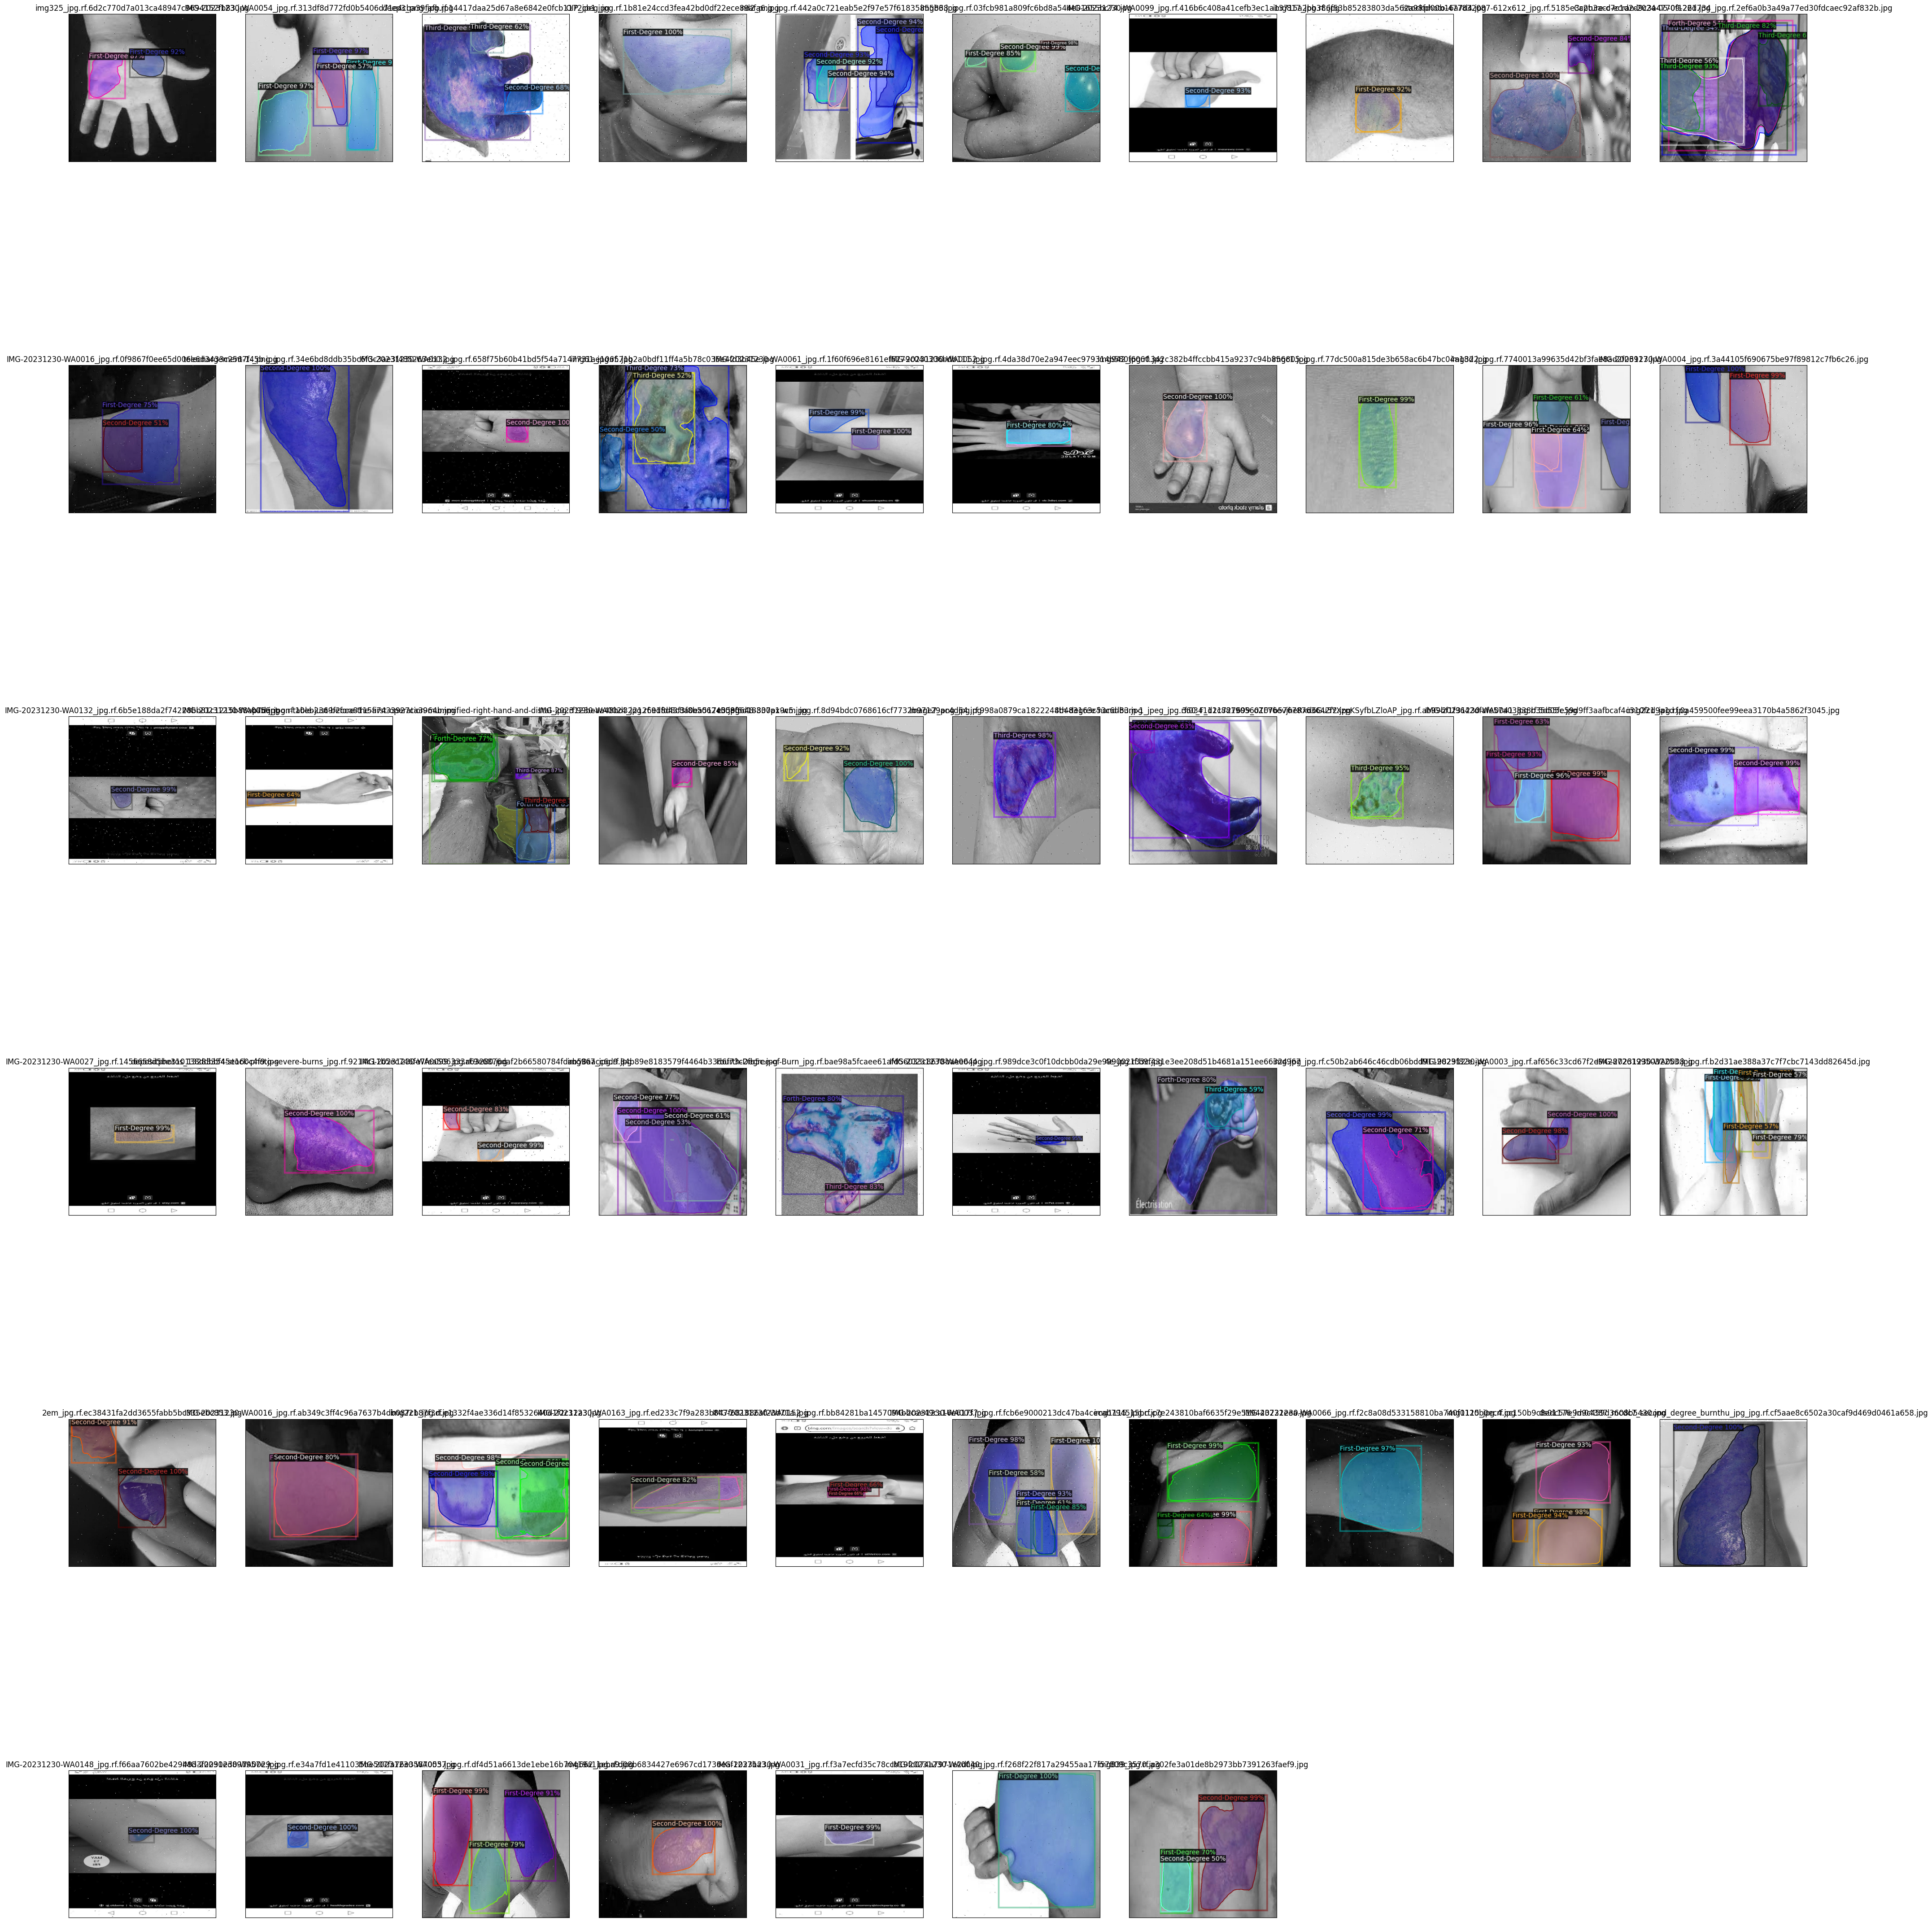

In [46]:
import matplotlib.pyplot as plt 
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'wound_seg_320.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

wound_metadata = MetadataCatalog.get("roboflow_burn_test")
test_dicts = DatasetCatalog.get("roboflow_burn_test")

fig=plt.figure(figsize=(50,100))
columns = 10
rows = 10

for i, d in enumerate(test_dicts):
    if(i >= 100):
      break
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wound_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    ax = fig.add_subplot(rows, columns, i + 1)

    ax.set_title(f'{d["file_name"].split("/")[-1]}')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)
    ax.imshow(out.get_image()[:, :, ::-1])

plt.show()